In [1]:
from mimic.utilities import *
from mimic.utilities.utilities import plot_CRM, plot_CRM_with_intervals

from mimic.model_infer.infer_CRM_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_CRM import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as azS
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle

from scipy import stats
from scipy.integrate import odeint


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Bayesian inference to infer the parameters of a Consumer Resource model

The Consumer Resource equation based on the MacArthur model takes the form

$$
dN_i = \frac{N_i}{\tau} \cdot \left( c_{ij} \cdot (w \cdot R)_j - m_i \right)
$$

$$
dR_j = \frac{1}{r \cdot K_j} \cdot (K_j - R_j) \cdot R_j - (N_i \cdot c_{ij} \cdot R_j)
$$


where:
-   $N$ is the concentration of each species
-   $\tau$ is the species timescale
-   $m$ is the species mortality rate
-   $R$ is the concentration of each resource
-   $r$ is the resource timescale
-   $w$ is the quality of each resource
-   $K$ is the resource capacity
-   $c$ is each species' preference for each resource



Unlike the gLV, the CRM is not linearised, so the DifferentialEquation function from pymc is utilised to solve the ODEs within the inference function. This can take a while if inferring all parameters, so below we demonstrate run_inference by inferring only one parameter (c) while the rest remain fixed, where inferring all parameters takes longer.

## Read in simulated data
The data was simulated examples-sim-CRM.ipynb

In [5]:
with open("params-s2-r2.pkl", "rb") as f:
    params = pickle.load(f)
tau = params["tau"]
m = params["m"]
r = params["r"]
w = params["w"]
K = params["K"]
c = params["c"]

# read in the data

data = pd.read_csv("data-s2-r2.csv")

times = data.iloc[:, 0].values
yobs = data.iloc[:, 1:6].values

print(params)

{'num_species': 2, 'num_resources': 2, 'tau': array([0.6, 0.9]), 'w': array([0.5, 0.6]), 'c': array([[0.25, 0.08],
       [0.06, 0.22]]), 'm': array([0.25, 0.28]), 'r': array([0.4 , 0.35]), 'K': array([5., 6.])}


## Infer parameter c only
While parameters tau, m, r, w and K remain fixed to true values generated by the simulation. Any combination of parameters can be inferred by providing the prior_mean and prior_sigma instead of the true value

times shape: (100,)
yobs shape: (100, 4)
Number of species: 2
Number of resources: 2
tau_hat is fixed
w_hat is fixed
c_hat is inferred
m_hat is fixed
r_hat is fixed
K_hat is fixed
=== CRITICAL: TESTING IF MODEL STRUCTURE IS CORRECT ===
RMSE with near-true parameters: 1.715443
Data scale: 4.327
Model scale: 5.597
First few predictions: [[10.         10.         10.         10.        ]
 [10.88000607 10.81641725  6.89955835  7.34749295]
 [11.47441219 11.37674504  5.25535067  5.8592082 ]]
First few observations: [[10.13075552  9.95778209  9.84300275  9.93706714]
 [11.94937971 11.32061726  6.169857    6.39564617]
 [13.46658583 12.13141828  4.11131474  4.55146298]]
nsp_tensor: [2], nr_tensor: [2]
tau_hat: [0.6 0.9], w_hat: [0.5 0.6]
c_hat: [[0.06569039 0.09474631]
 [0.13355162 0.08497668]], m_hat: [0.25 0.28]
r_hat: [0.4  0.35], K_hat: [5. 6.]
theta: [2.         2.         0.6        0.9        0.5        0.6
 0.06569039 0.09474631 0.13355162 0.08497668 0.25       0.28
 0.4        0.35     

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c_hat_vals]


Output()

/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(
/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1000000000000D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.2000000000000D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.2000000000000D+00
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN

/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(
/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1389 seconds.


Parameter tau_hat not found in posterior samples, skipping plot.
Parameter w_hat not found in posterior samples, skipping plot.
Plotting posterior for c_hat
Added true value line for c_hat: [[0.25 0.08]
 [0.06 0.22]]


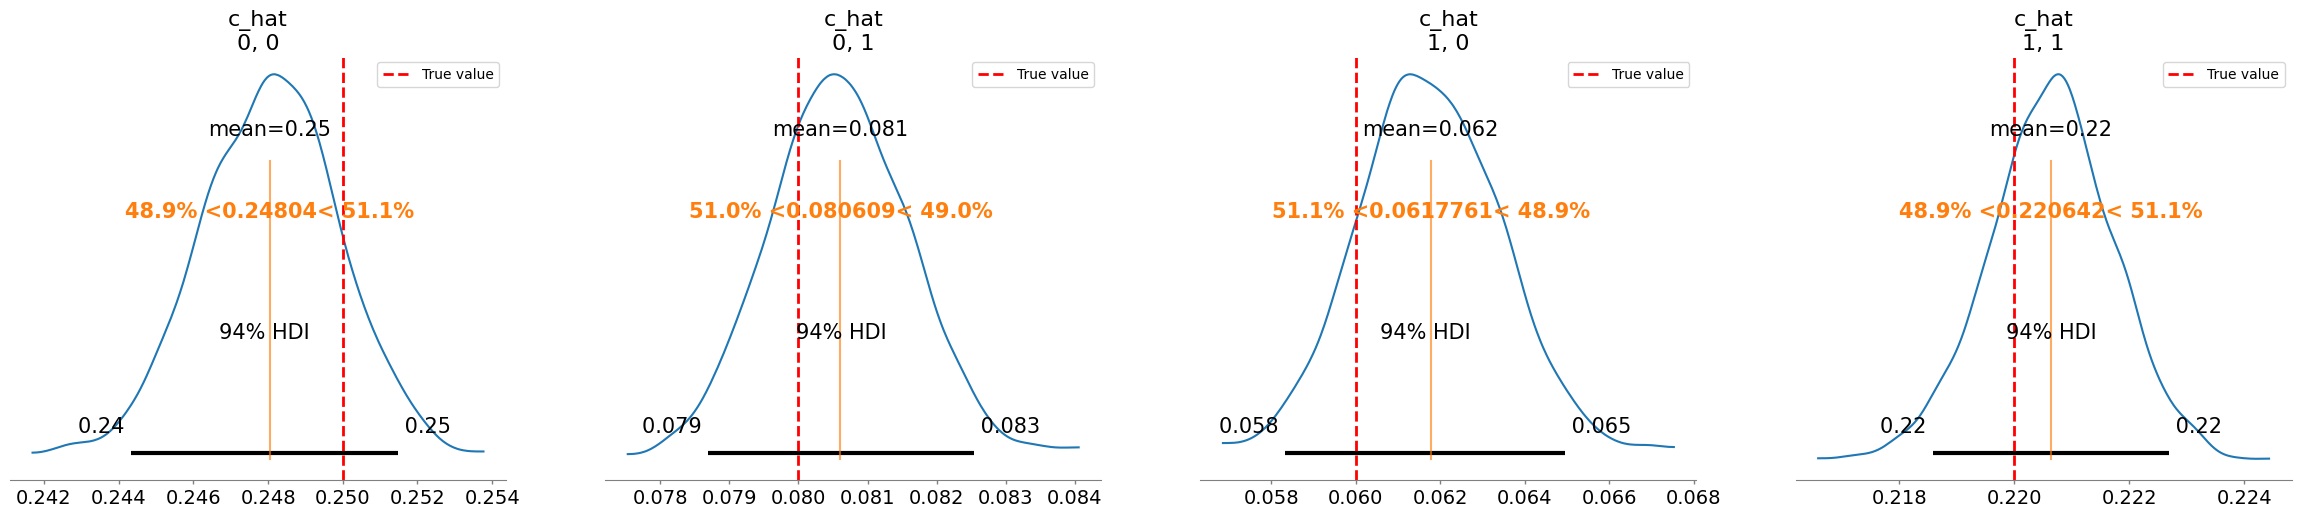

Parameter m_hat not found in posterior samples, skipping plot.
Parameter r_hat not found in posterior samples, skipping plot.
Parameter K_hat not found in posterior samples, skipping plot.
              mean     sd  r_hat
c_hat[0, 0]  0.248  0.002   1.00
c_hat[0, 1]  0.081  0.001   1.01
c_hat[1, 0]  0.062  0.002   1.00
c_hat[1, 1]  0.221  0.001   1.00
sigma[0]     0.098  0.004   1.01


'model_posterior.nc'

In [3]:
num_species = 2
num_resources = 2

# fixed parameters
tau = params["tau"]
#c = params["c"]
m = params["m"]
r = params["r"]
w = params["w"]
K = params["K"]

# Define prior for c (resource preference matrix)
# prior_c_mean = 0.65
# prior_c_sigma = 0.2

#prior_r_mean = 0.55
#prior_r_sigma = 0.2

prior_c_mean = 0.15
prior_c_sigma = 0.1


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

inference = inferCRMbayes()

inference.set_parameters(times=times, yobs=yobs, num_species=num_species, num_resources=num_resources,
                         tau=tau, w=w, K=K, r=r, m=m, 
                         prior_c_mean=prior_c_mean, prior_c_sigma=prior_c_sigma,
                         draws=draws, tune=tune, chains=chains, cores=cores)

idata = inference.run_inference()

# To plot posterior distributions
inference.plot_posterior(idata, true_params=params)


summary = az.summary(idata, var_names=["c_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')



array([[<Axes: title={'center': 'c_hat'}>,
        <Axes: title={'center': 'c_hat'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

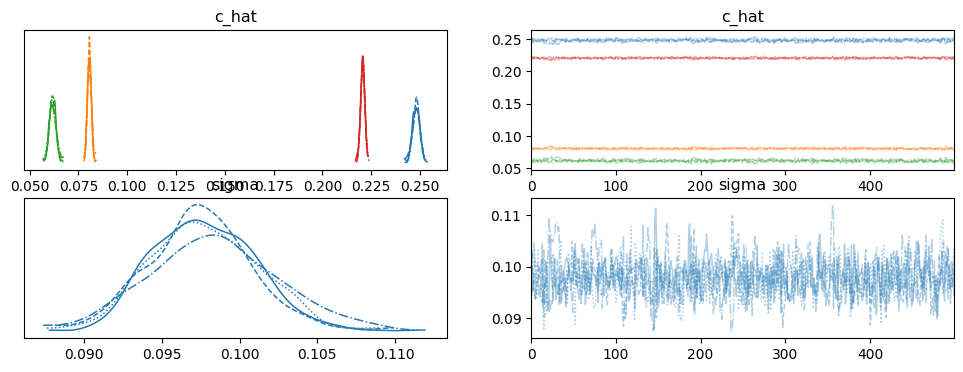

In [4]:
# Plot the trace of the posterior samples
az.plot_trace(idata, var_names=["c_hat", "sigma"])


c_hat/c:
[[0.25 0.08]
 [0.06 0.22]]

 [[0.25 0.08]
 [0.06 0.22]]


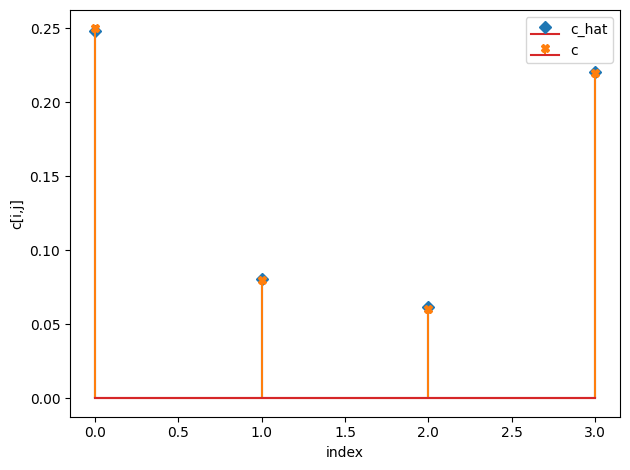

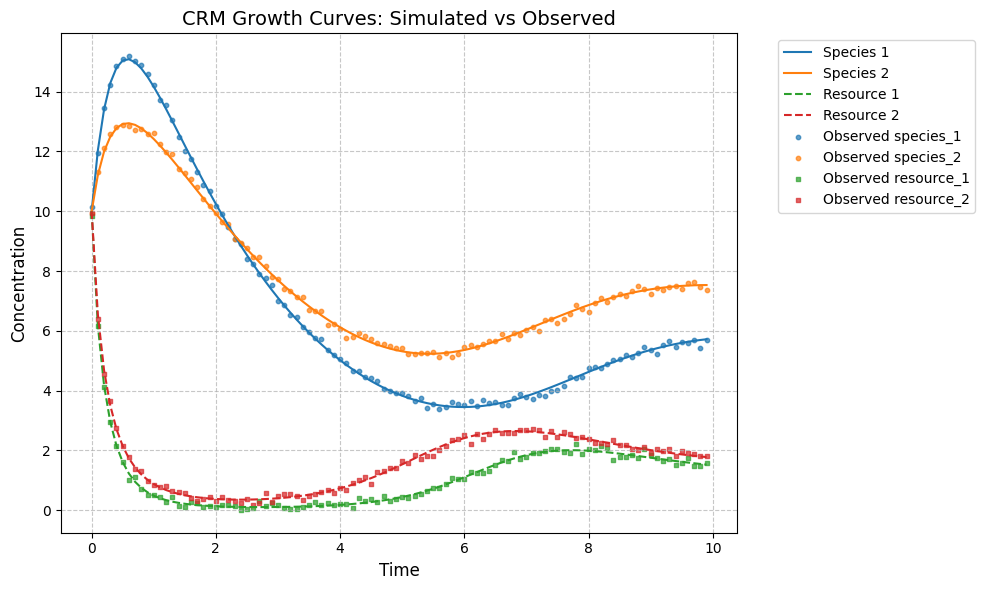

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'CRM Growth Curves: Simulated vs Observed'}, xlabel='Time', ylabel='Concentration'>)

In [5]:
# Plot the CRM

init_species = 10 * np.ones(num_species+num_resources)

# inferred parameters
c_h = np.median(idata.posterior["c_hat"].values, axis=(0,1))

compare_params(c=(c, c_h))

predictor = sim_CRM()

predictor.set_parameters(num_species = num_species,
                         num_resources = num_resources,
                         tau = tau,
                         w = w,
                         c = c_h,
                         m = m,
                         r = r,
                         K = K)

#predictor.print_parameters()

observed_species, observed_resources = predictor.simulate(times, init_species)
observed_data = np.hstack((observed_species, observed_resources))
 
# plot predicted species and resouce dynamics against observed data

plot_CRM(observed_species, observed_resources, times, 'data-s2-r2.csv')

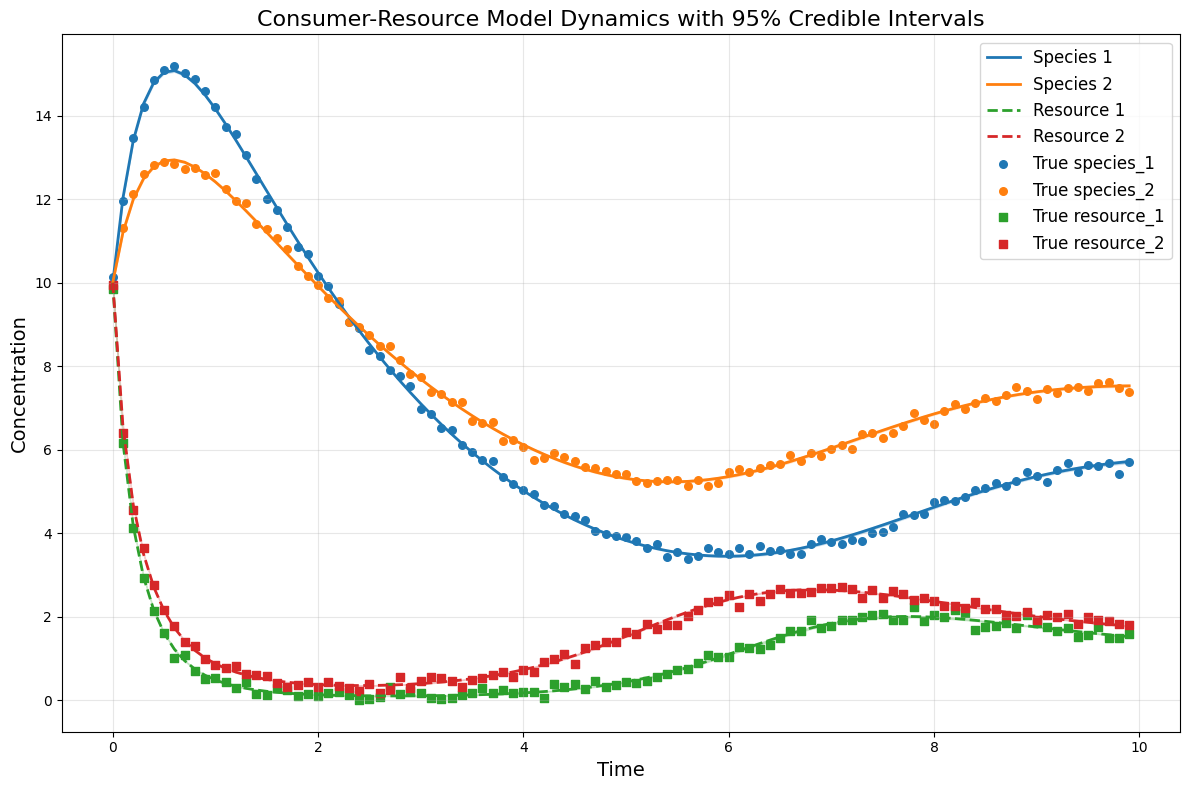

In [6]:
## Plot CRM  with confidence intervals

# Get posterior samples for c_hat 
c_posterior_samples = idata.posterior["c_hat"].values 

lower_percentile = 2.5
upper_percentile = 97.5

n_samples = 50
random_indices = np.random.choice(c_posterior_samples.shape[1], size=n_samples, replace=False)

# Store simulation results
all_species_trajectories = []
all_resource_trajectories = []

# Run simulations with different posterior samples
for i in range(n_samples):
    chain_idx = np.random.randint(0, c_posterior_samples.shape[0])
    c_sample = c_posterior_samples[chain_idx, random_indices[i]]
    
    sample_predictor = sim_CRM()
    sample_predictor.set_parameters(num_species=num_species,
                                   num_resources=num_resources,
                                   tau=tau,
                                   w=w,
                                   c=c_sample,
                                   m=m,
                                   r=r,
                                   K=K)
    
    sample_species, sample_resources = sample_predictor.simulate(times, init_species)
    
    # Store results
    all_species_trajectories.append(sample_species)
    all_resource_trajectories.append(sample_resources)

# Convert to numpy arrays
all_species_trajectories = np.array(all_species_trajectories)  
all_resource_trajectories = np.array(all_resource_trajectories)  

# Calculate percentiles across samples for each time point and species/resource
species_lower = np.percentile(all_species_trajectories, lower_percentile, axis=0)
species_upper = np.percentile(all_species_trajectories, upper_percentile, axis=0)
resource_lower = np.percentile(all_resource_trajectories, lower_percentile, axis=0)
resource_upper = np.percentile(all_resource_trajectories, upper_percentile, axis=0)


# plot the CRM with confidence intervals
plot_CRM_with_intervals(observed_species, observed_resources, 
                       species_lower, species_upper,
                       resource_lower, resource_upper,
                       times, 'data-s2-r2.csv')

# Infer all parameters

In [7]:
num_species = 2
num_resources = 2

# fixed parameters
# tau = params["tau"]
# c = params["c"]
# m = params["m"]
# r = params["r"]
# w = params["w"]
# K = params["K"]

# Define prior for c (resource preference matrix)



prior_tau_mean = 0.7
prior_tau_sigma = 0.2

prior_w_mean = 0.55
prior_w_sigma = 0.2

prior_c_mean = 0.15
prior_c_sigma = 0.1

prior_m_mean = 0.25
prior_m_sigma = 0.1

prior_r_mean = 0.4
prior_r_sigma = 0.1

prior_K_mean = 5.5
prior_K_sigma = 0.5



# Sampling conditions
draws = 250
tune = 250
chains = 4
cores = 4

inference = inferCRMbayes()

inference.set_parameters(times=times, yobs=yobs, num_species=num_species, num_resources=num_resources,
                            prior_tau_mean=prior_tau_mean, prior_tau_sigma=prior_tau_sigma,
                            prior_w_mean=prior_w_mean, prior_w_sigma=prior_w_sigma,
                            prior_c_mean=prior_c_mean, prior_c_sigma=prior_c_sigma,
                            prior_m_mean=prior_m_mean, prior_m_sigma=prior_m_sigma,
                            prior_r_mean=prior_r_mean, prior_r_sigma=prior_r_sigma,
                            prior_K_mean=prior_K_mean, prior_K_sigma=prior_K_sigma,
                         draws=draws, tune=tune, chains=chains, cores=cores)

idata = inference.run_inference()

# To plot posterior distributions
inference.plot_posterior(idata, true_params=params)


summary = az.summary(idata, var_names=["tau_hat", "w_hat","c_hat", "m_hat", "r_hat", "K_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')



times shape: (100,)
yobs shape: (100, 4)
Number of species: 2
Number of resources: 2
tau_hat is inferred
w_hat is inferred
c_hat is inferred
m_hat is inferred
r_hat is inferred
K_hat is inferred
=== CRITICAL: TESTING IF MODEL STRUCTURE IS CORRECT ===
RMSE with near-true parameters: 2.072147
Data scale: 4.327
Model scale: 4.969
First few predictions: [[10.         10.         10.         10.        ]
 [10.78653783 11.46945439  6.41339204  5.87260415]
 [11.23759716 12.47147213  4.58384006  4.097787  ]]
First few observations: [[10.13075552  9.95778209  9.84300275  9.93706714]
 [11.94937971 11.32061726  6.169857    6.39564617]
 [13.46658583 12.13141828  4.11131474  4.55146298]]
nsp_tensor: [2], nr_tensor: [2]
tau_hat: [0.9598066  1.22473318], w_hat: [0.58013985 0.57631784]
c_hat: [[0.10402891 0.11535682]
 [0.21631836 0.21402456]], m_hat: [0.25853101 0.25659152]
r_hat: [0.29697055 0.25216102], K_hat: [6.1128411  5.20636317]
theta: [2.         2.         0.9598066  1.22473318 0.58013985 0.5

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau_hat, w_hat, c_hat_vals, m_hat, r_hat, K_hat]


Output()

/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(
/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN


/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN


ValueError: Not enough samples to build a trace.


tau_hat/tau:
[0.51 0.47]

 [0.6 0.9]


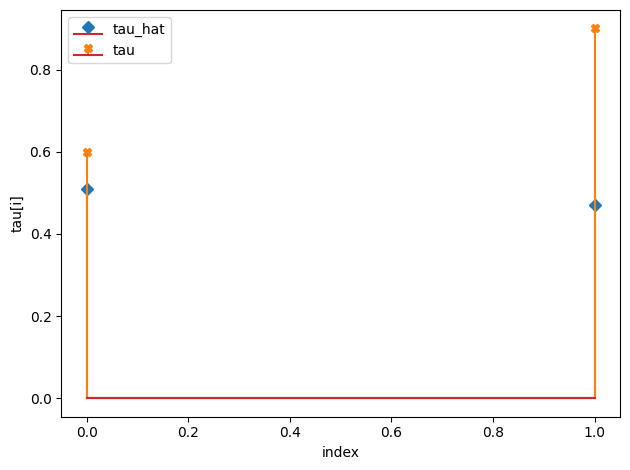


w_hat/w:
[0.4  0.35]

 [0.5 0.6]


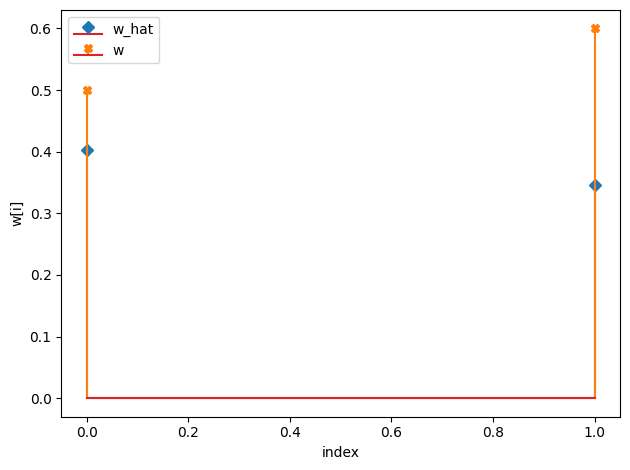


c_hat/c:
[[0.24 0.12]
 [0.08 0.16]]

 [[0.25 0.08]
 [0.06 0.22]]


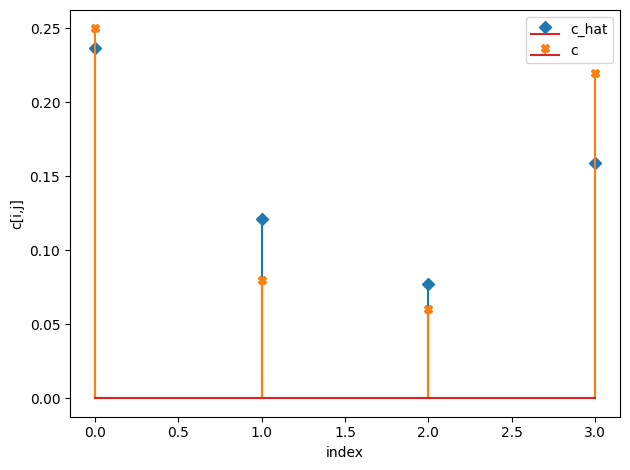


m_hat/m:
[0.22 0.13]

 [0.25 0.28]


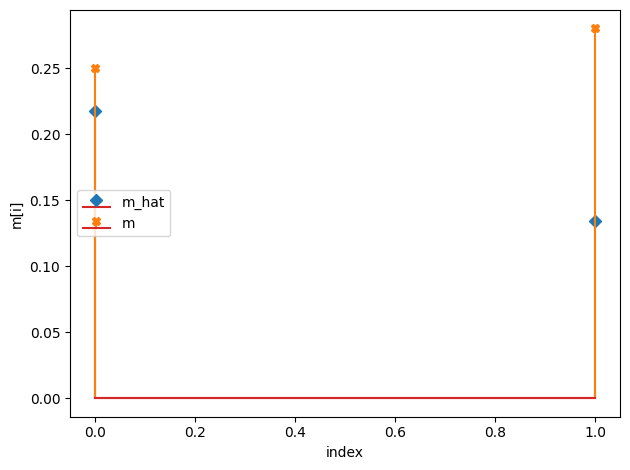


r_hat/r:
[0.4  0.36]

 [0.4  0.35]


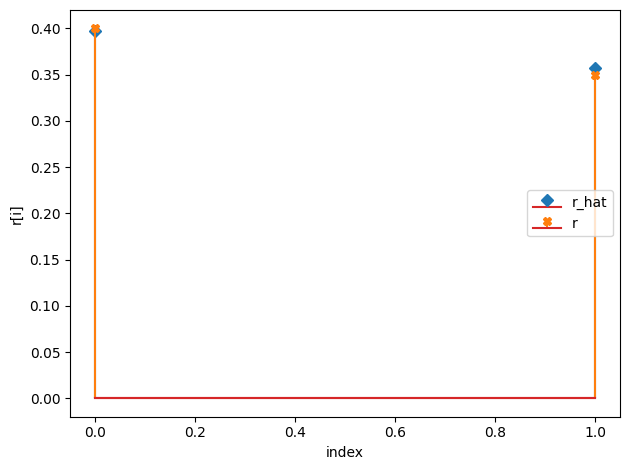


K_hat/K:
[5.27 5.32]

 [5. 6.]


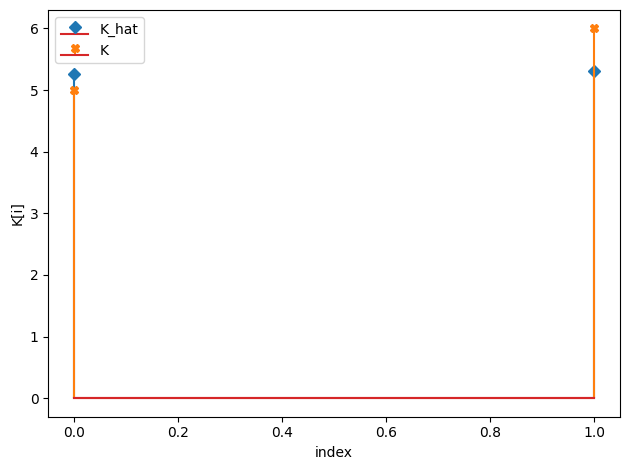

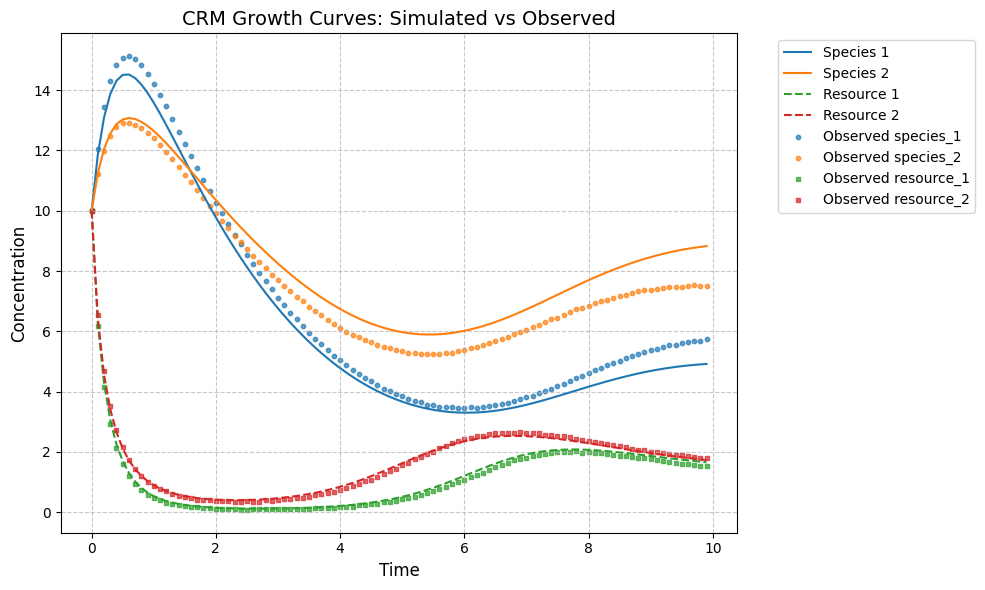

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'CRM Growth Curves: Simulated vs Observed'}, xlabel='Time', ylabel='Concentration'>)

In [8]:
# Plot the CRM

init_species = 10 * np.ones(num_species+num_resources)

# inferred parameters
tau_h = np.median(idata.posterior["tau_hat"].values, axis=(0,1))
w_h = np.median(idata.posterior["w_hat"].values, axis=(0,1))
c_h = np.median(idata.posterior["c_hat"].values, axis=(0,1))
m_h = np.median(idata.posterior["m_hat"].values, axis=(0,1))
r_h = np.median(idata.posterior["r_hat"].values, axis=(0,1))
K_h = np.median(idata.posterior["K_hat"].values, axis=(0,1))

compare_params(tau=(tau, tau_h), w=(w, w_h), c=(c, c_h), m=(m, m_h), r=(r, r_h), K=(K, K_h))

predictor = sim_CRM()

predictor.set_parameters(num_species = num_species,
                         num_resources = num_resources,
                         tau = tau_h,
                         w = w_h,
                         c = c_h,
                         m = m_h,
                         r = r_h,
                         K = K_h)

#predictor.print_parameters()

observed_species, observed_resources = predictor.simulate(times, init_species)
observed_data = np.hstack((observed_species, observed_resources))
 
# plot predicted species and resouce dynamics against observed data

plot_CRM(observed_species, observed_resources, times, 'data-s2-r2.csv')

In [ ]:
## Plot CRM  with confidence intervals

# Get posterior samples for c_hat 
c_posterior_samples = idata.posterior["c_hat"].values 

lower_percentile = 2.5
upper_percentile = 97.5

n_samples = 50
random_indices = np.random.choice(c_posterior_samples.shape[1], size=n_samples, replace=False)

# Store simulation results
all_species_trajectories = []
all_resource_trajectories = []

# Run simulations with different posterior samples
for i in range(n_samples):
    chain_idx = np.random.randint(0, c_posterior_samples.shape[0])
    c_sample = c_posterior_samples[chain_idx, random_indices[i]]
    
    sample_predictor = sim_CRM()
    sample_predictor.set_parameters(num_species=num_species,
                                   num_resources=num_resources,
                                   tau=tau,
                                   w=w,
                                   c=c_sample,
                                   m=m,
                                   r=r,
                                   K=K)
    
    sample_species, sample_resources = sample_predictor.simulate(times, init_species)
    
    # Store results
    all_species_trajectories.append(sample_species)
    all_resource_trajectories.append(sample_resources)

# Convert to numpy arrays
all_species_trajectories = np.array(all_species_trajectories)  
all_resource_trajectories = np.array(all_resource_trajectories)  

# Calculate percentiles across samples for each time point and species/resource
species_lower = np.percentile(all_species_trajectories, lower_percentile, axis=0)
species_upper = np.percentile(all_species_trajectories, upper_percentile, axis=0)
resource_lower = np.percentile(all_resource_trajectories, lower_percentile, axis=0)
resource_upper = np.percentile(all_resource_trajectories, upper_percentile, axis=0)


# plot the CRM with confidence intervals
plot_CRM_with_intervals(observed_species, observed_resources, 
                       species_lower, species_upper,
                       resource_lower, resource_upper,
                       times, 'data-s2-r2.csv')

# Using only species data, infer resource concentration

{'num_species': 2, 'num_resources': 2, 'tau': array([0.6, 0.9]), 'w': array([0.5, 0.6]), 'c': array([[0.25, 0.08],
       [0.06, 0.22]]), 'm': array([0.25, 0.28]), 'r': array([0.4 , 0.35]), 'K': array([5., 6.])}
[[ 9.99394166  9.89957073]
 [12.00265551 11.21044161]
 [13.3618914  12.04261137]
 [14.33843776 12.44382017]
 [14.82035602 12.84805998]
 [15.12285208 12.90998688]
 [15.04948901 12.9983141 ]
 [15.07148389 12.85380922]
 [14.78545571 12.7359763 ]
 [14.47296529 12.56154704]
 [14.24003097 12.30188608]
 [13.82041404 12.18159384]
 [13.45335285 11.88389378]
 [12.98808939 11.75275712]
 [12.57873255 11.49673126]
 [12.20735416 11.24393316]
 [11.80438777 10.87331634]
 [11.46742411 10.67239352]
 [11.10336494 10.46088776]
 [10.63444031 10.13934848]
 [10.27172776  9.9203375 ]
 [ 9.86151319  9.70606955]
 [ 9.53165117  9.40067621]
 [ 9.1815826   9.19638408]
 [ 8.84245445  8.9600867 ]
 [ 8.69522828  8.7249386 ]
 [ 8.22641928  8.42451177]
 [ 7.95315245  8.23888522]
 [ 7.64556214  8.09469538]
 [ 7.

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


tau_hat is fixed
w_hat is fixed
c_hat is inferred
m_hat is fixed
r_hat is fixed
K_hat is fixed
=== CRITICAL: TESTING IF MODEL STRUCTURE IS CORRECT ===
MODEL FAILED: operands could not be broadcast together with shapes (100,4) (100,2) 
nsp_tensor: [2], nr_tensor: [2]
tau_hat: [0.6 0.9], w_hat: [0.5 0.6]
c_hat: [[0.18037273 0.00144236]
 [0.18943669 0.1286244 ]], m_hat: [0.25 0.28]
r_hat: [0.4  0.35], K_hat: [5. 6.]
theta: [2.00000000e+00 2.00000000e+00 6.00000000e-01 9.00000000e-01
 5.00000000e-01 6.00000000e-01 1.80372728e-01 1.44235737e-03
 1.89436692e-01 1.28624405e-01 2.50000000e-01 2.80000000e-01
 4.00000000e-01 3.50000000e-01 5.00000000e+00 6.00000000e+00]
Initial conditions (y0): [10. 10. 10. 10.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c_hat_vals]


Output()

/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(
/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(
/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1000000000000D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.2000000000000D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.2000000000000D+00
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN

/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(
/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN


Sampling 4 chains for 50 tune and 50 draw iterations (200 + 200 draws total) took 115 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


Parameter tau_hat not found in posterior samples, skipping plot.
Parameter w_hat not found in posterior samples, skipping plot.
Plotting posterior for c_hat
Added true value line for c_hat: [[0.25 0.08]
 [0.06 0.22]]


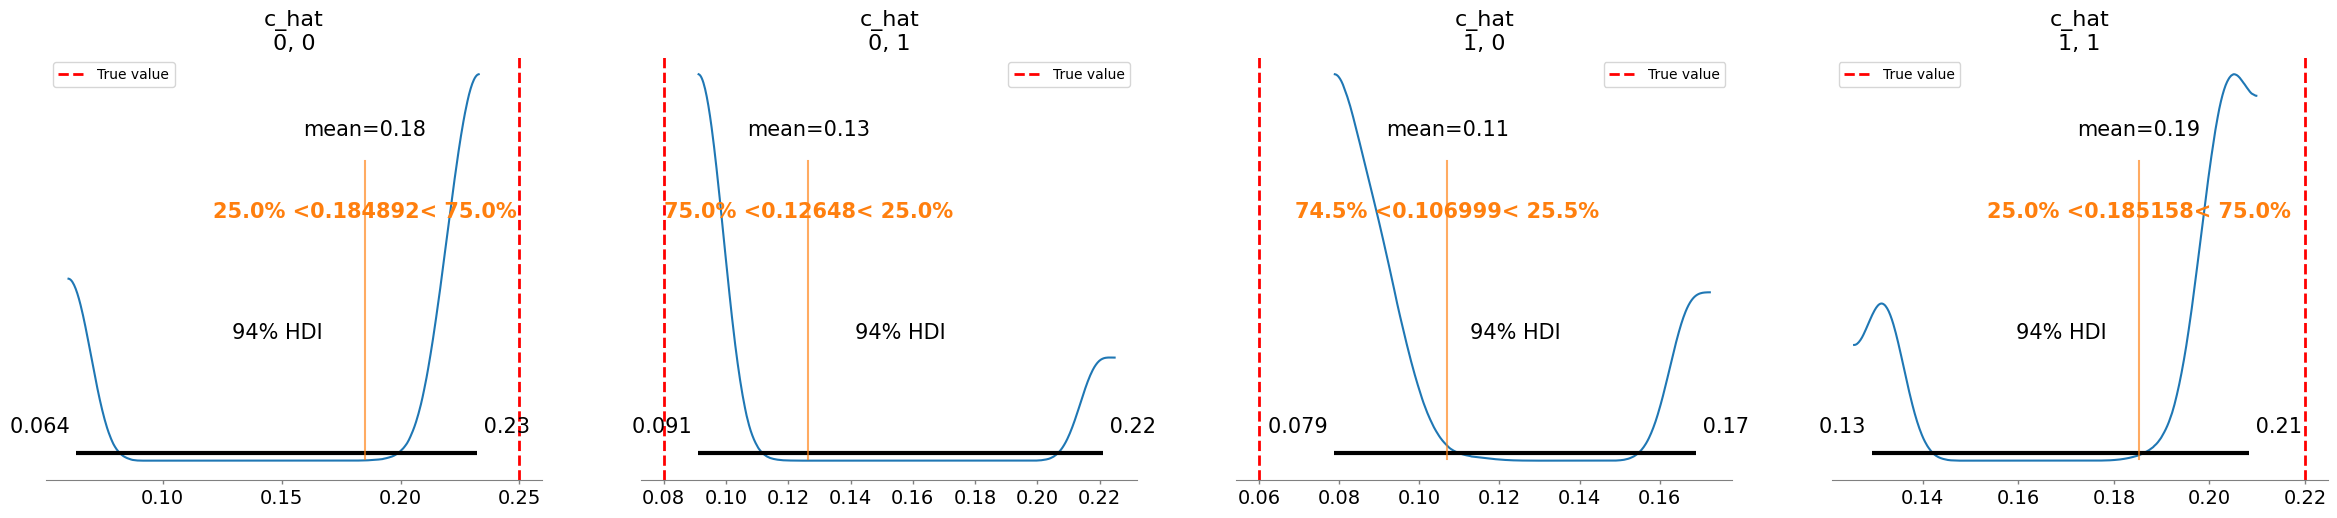

Parameter m_hat not found in posterior samples, skipping plot.
Parameter r_hat not found in posterior samples, skipping plot.
Parameter K_hat not found in posterior samples, skipping plot.
              mean     sd  r_hat
c_hat[0, 0]  0.185  0.070   3.03
c_hat[0, 1]  0.126  0.054   2.99
c_hat[1, 0]  0.107  0.035   3.04
c_hat[1, 1]  0.185  0.031   3.10
sigma[0]     0.183  0.036   3.52


'model_posterior.nc'

In [6]:
data = pd.read_csv("data-s2-infer-r2.csv")

times = data.iloc[:, 0].values
yobs = data.iloc[:, 1:3].values

print(params)
print(yobs)

num_species = 2
num_resources = 2

# fixed parameters
tau = params["tau"]
#c = params["c"]
m = params["m"]
r = params["r"]
w = params["w"]
K = params["K"]

# Define prior for c (resource preference matrix)

prior_c_mean = 0.15
prior_c_sigma = 0.1


# Sampling conditions
draws = 50
tune = 50
chains = 4
cores = 4

inference = inferCRMbayes()

inference.set_parameters(times=times, yobs=yobs, num_species=num_species, num_resources=num_resources,
                         tau=tau, w=w, K=K, r=r, m=m, 
                         prior_c_mean=prior_c_mean, prior_c_sigma=prior_c_sigma,
                         draws=draws, tune=tune, chains=chains, cores=cores)

idata = inference.run_inference()

# To plot posterior distributions
inference.plot_posterior(idata, true_params=params)


summary = az.summary(idata, var_names=["c_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')



array([[<Axes: title={'center': 'c_hat'}>,
        <Axes: title={'center': 'c_hat'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

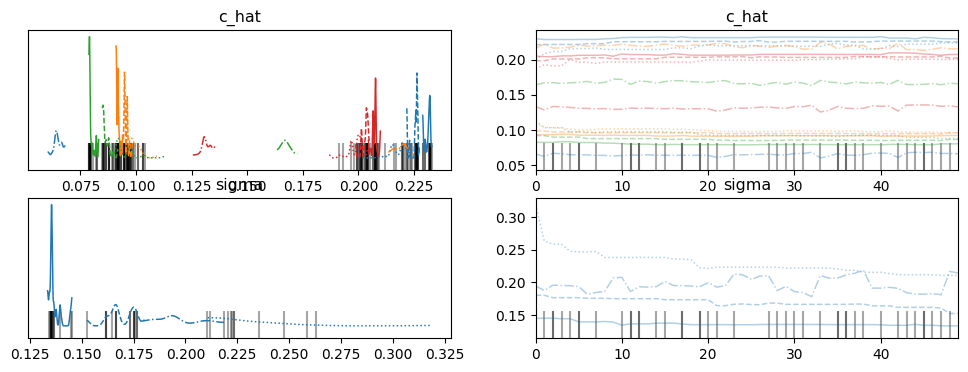

In [7]:
# Plot the trace of the posterior samples
az.plot_trace(idata, var_names=["c_hat", "sigma"])


c_hat/c:
[[0.22 0.1 ]
 [0.09 0.2 ]]

 [[0.25 0.08]
 [0.06 0.22]]


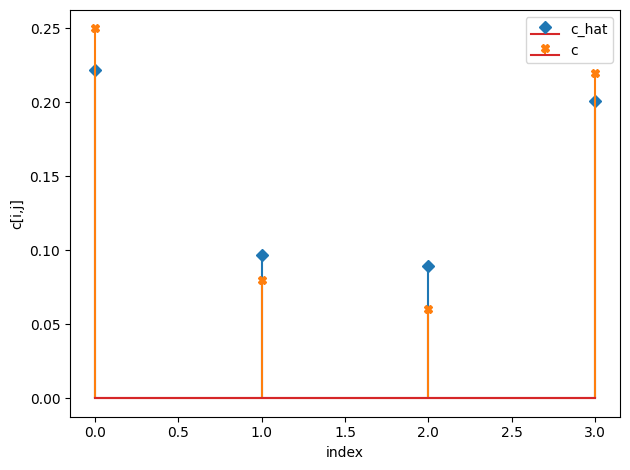

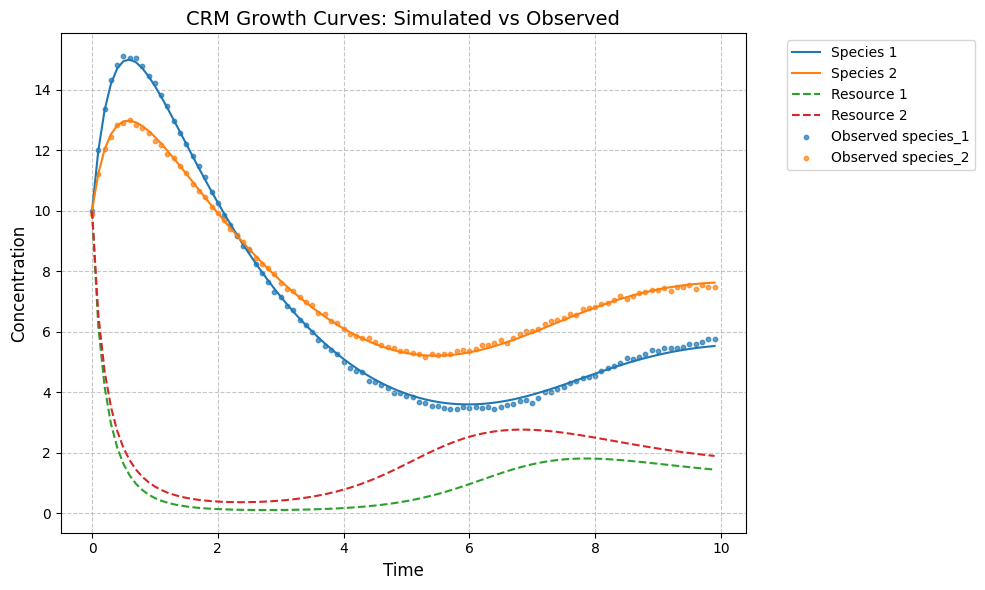

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'CRM Growth Curves: Simulated vs Observed'}, xlabel='Time', ylabel='Concentration'>)

In [8]:
# Plot the CRM

init_species = 10 * np.ones(num_species+num_resources)

# inferred parameters
c_h = np.median(idata.posterior["c_hat"].values, axis=(0,1))

compare_params(c=(c, c_h))

predictor = sim_CRM()

predictor.set_parameters(num_species = num_species,
                         num_resources = num_resources,
                         tau = tau,
                         w = w,
                         c = c_h,
                         m = m,
                         r = r,
                         K = K)

#predictor.print_parameters()

observed_species, observed_resources = predictor.simulate(times, init_species)
observed_data = np.hstack((observed_species, observed_resources))
 
# plot predicted species and resouce dynamics against observed data

plot_CRM(observed_species, observed_resources, times, 'data-s2-infer-r2.csv')

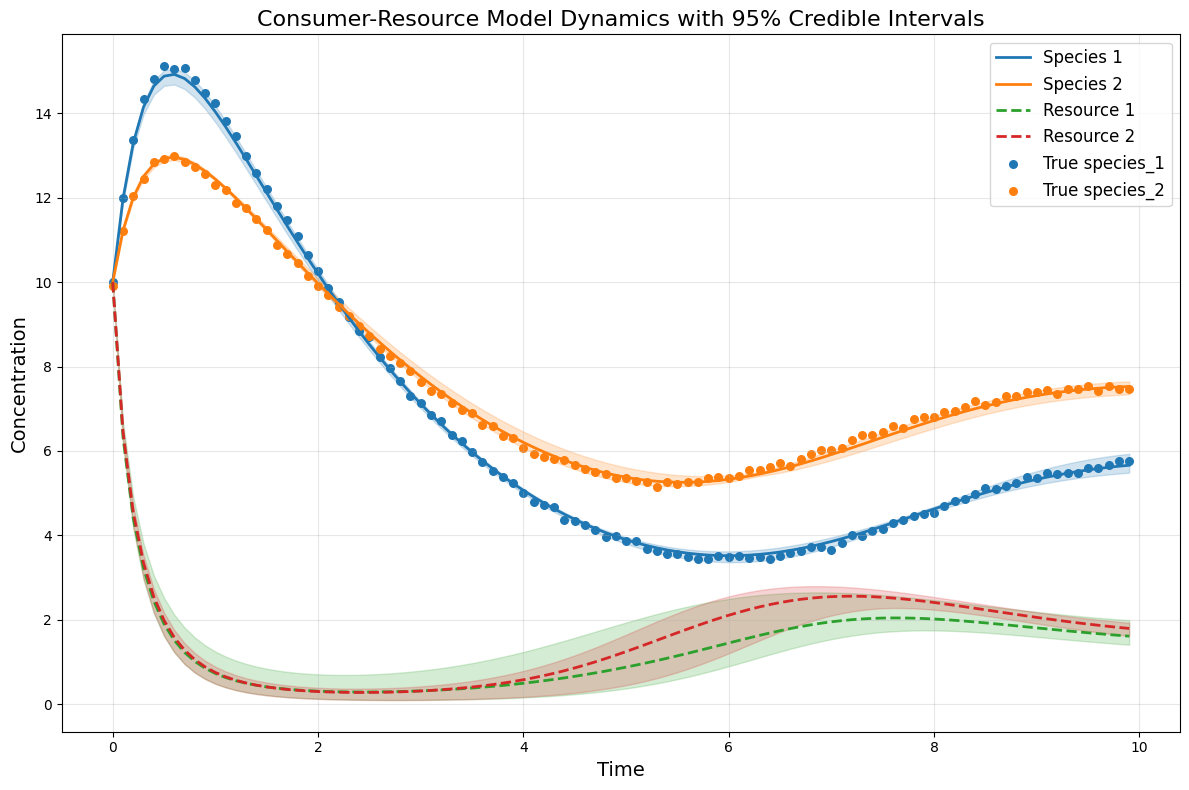

In [9]:
## Plot CRM  with confidence intervals

# Get posterior samples for c_hat 
c_posterior_samples = idata.posterior["c_hat"].values 

lower_percentile = 2.5
upper_percentile = 97.5

n_samples = 50
random_indices = np.random.choice(c_posterior_samples.shape[1], size=n_samples, replace=False)

# Store simulation results
all_species_trajectories = []
all_resource_trajectories = []

# Run simulations with different posterior samples
for i in range(n_samples):
    chain_idx = np.random.randint(0, c_posterior_samples.shape[0])
    draw_idx = np.random.randint(0, c_posterior_samples.shape[1])

    c_sample = c_posterior_samples[chain_idx, draw_idx]
    
    sample_predictor = sim_CRM()
    sample_predictor.set_parameters(num_species=num_species,
                                   num_resources=num_resources,
                                   tau=tau,
                                   w=w,
                                   c=c_sample,
                                   m=m,
                                   r=r,
                                   K=K)
    
    
    sample_species, sample_resources = sample_predictor.simulate(times, init_species)
    
    # Store results
    all_species_trajectories.append(sample_species)
    all_resource_trajectories.append(sample_resources)


# Convert to numpy arrays
all_species_trajectories = np.array(all_species_trajectories)  
all_resource_trajectories = np.array(all_resource_trajectories)  

# Calculate percentiles across samples for each time point and species/resource
species_lower = np.percentile(all_species_trajectories, lower_percentile, axis=0)
species_upper = np.percentile(all_species_trajectories, upper_percentile, axis=0)
resource_lower = np.percentile(all_resource_trajectories, lower_percentile, axis=0)
resource_upper = np.percentile(all_resource_trajectories, upper_percentile, axis=0)

observed_species_mean = np.mean(all_species_trajectories, axis=0)  # Predicted species means
observed_resources_mean = np.mean(all_resource_trajectories, axis=0)  # Predicted resources means

# plot the CRM with confidence intervals
plot_CRM_with_intervals(observed_species_mean, observed_resources_mean,
                       species_lower, species_upper,
                       resource_lower, resource_upper,
                       times, 'data-s2-infer-r2.csv')

# Infer all parameters when only given species data

In [ ]:
data = pd.read_csv("data-s2-infer-r2.csv")

times = data.iloc[:, 0].values
yobs = data.iloc[:, 1:3].values


num_species = 2
num_resources = 2


prior_tau_mean = 0.7
prior_tau_sigma = 0.2

prior_w_mean = 0.55
prior_w_sigma = 0.2

prior_c_mean = 0.15
prior_c_sigma = 0.1

prior_m_mean = 0.25
prior_m_sigma = 0.1

prior_r_mean = 0.4
prior_r_sigma = 0.1

prior_K_mean = 5.5
prior_K_sigma = 0.5



# Sampling conditions
draws = 200
tune = 200
chains = 4
cores = 4

inference = inferCRMbayes()

inference.set_parameters(times=times, yobs=yobs, num_species=num_species, num_resources=num_resources,
                            prior_tau_mean=prior_tau_mean, prior_tau_sigma=prior_tau_sigma,
                            prior_w_mean=prior_w_mean, prior_w_sigma=prior_w_sigma,
                            prior_c_mean=prior_c_mean, prior_c_sigma=prior_c_sigma,
                            prior_m_mean=prior_m_mean, prior_m_sigma=prior_m_sigma,
                            prior_r_mean=prior_r_mean, prior_r_sigma=prior_r_sigma,
                            prior_K_mean=prior_K_mean, prior_K_sigma=prior_K_sigma,
                         draws=draws, tune=tune, chains=chains, cores=cores)

idata = inference.run_inference()

# To plot posterior distributions
inference.plot_posterior(idata, true_params=params)


summary = az.summary(idata, var_names=["tau_hat", "w_hat","c_hat", "m_hat", "r_hat", "K_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

times shape: (100,)
yobs shape: (100, 2)
Number of species: 2
Number of resources: 2
tau_hat is inferred
w_hat is inferred
c_hat is inferred
m_hat is inferred
r_hat is inferred
K_hat is inferred
=== CRITICAL: TESTING IF MODEL STRUCTURE IS CORRECT ===
MODEL FAILED: operands could not be broadcast together with shapes (100,4) (100,2) 
nsp_tensor: [2], nr_tensor: [2]
tau_hat: [0.83790865 0.61771527], w_hat: [0.85862258 0.51106388]
c_hat: [[0.04790821 0.26154852]
 [0.15444959 0.32360037]], m_hat: [0.25944519 0.36373094]
r_hat: [0.40526451 0.34769188], K_hat: [5.30127861 5.81092244]
theta: [2.         2.         0.83790865 0.61771527 0.85862258 0.51106388
 0.04790821 0.26154852 0.15444959 0.32360037 0.25944519 0.36373094
 0.40526451 0.34769188 5.30127861 5.81092244]
Initial conditions (y0): [10. 10. 10. 10.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau_hat, w_hat, c_hat_vals, m_hat, r_hat, K_hat]


Output()

/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(
/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN


/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN



tau_hat/tau:
[0.51 0.55]

 [0.6 0.9]


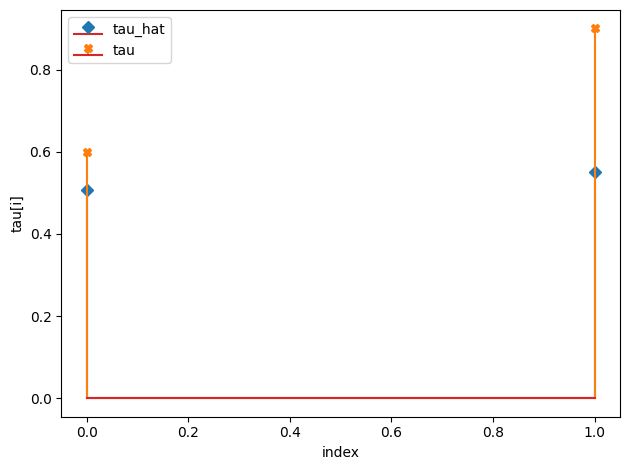


w_hat/w:
[0.39 0.42]

 [0.5 0.6]


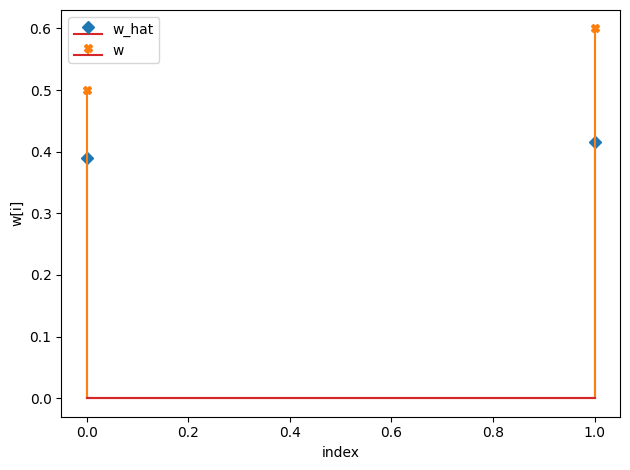


c_hat/c:
[[0.25 0.09]
 [0.05 0.22]]

 [[0.25 0.08]
 [0.06 0.22]]


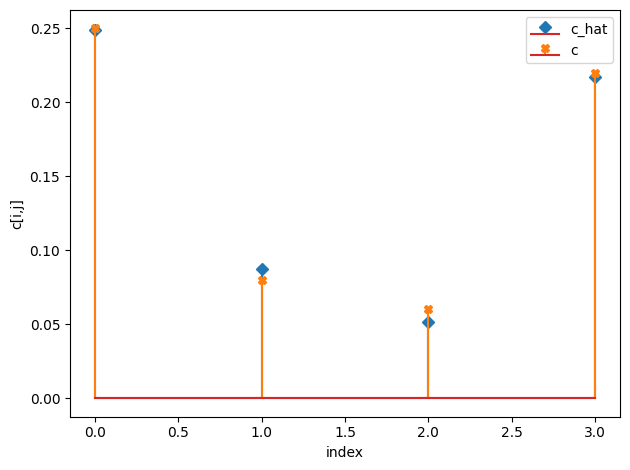


m_hat/m:
[0.21 0.17]

 [0.25 0.28]


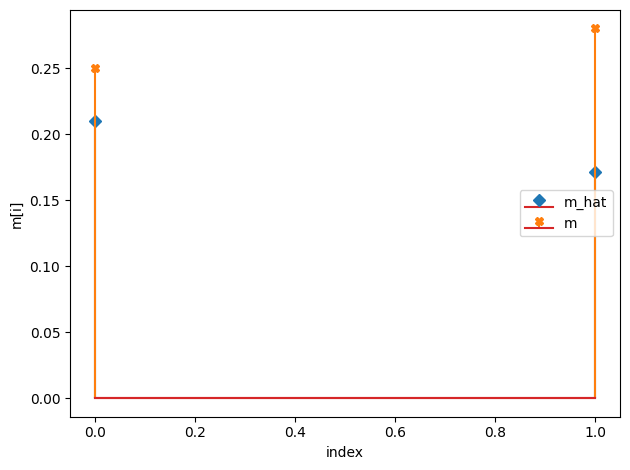


r_hat/r:
[0.41 0.35]

 [0.4  0.35]


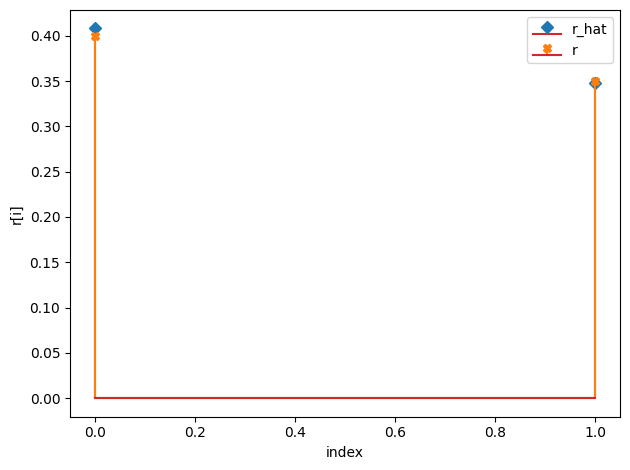


K_hat/K:
[4.93 5.67]

 [5. 6.]


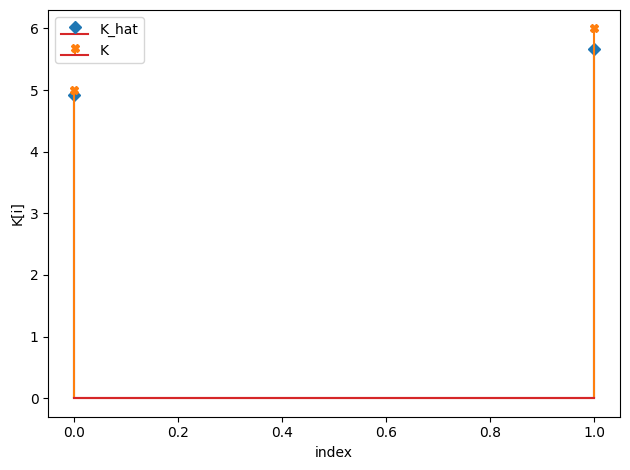

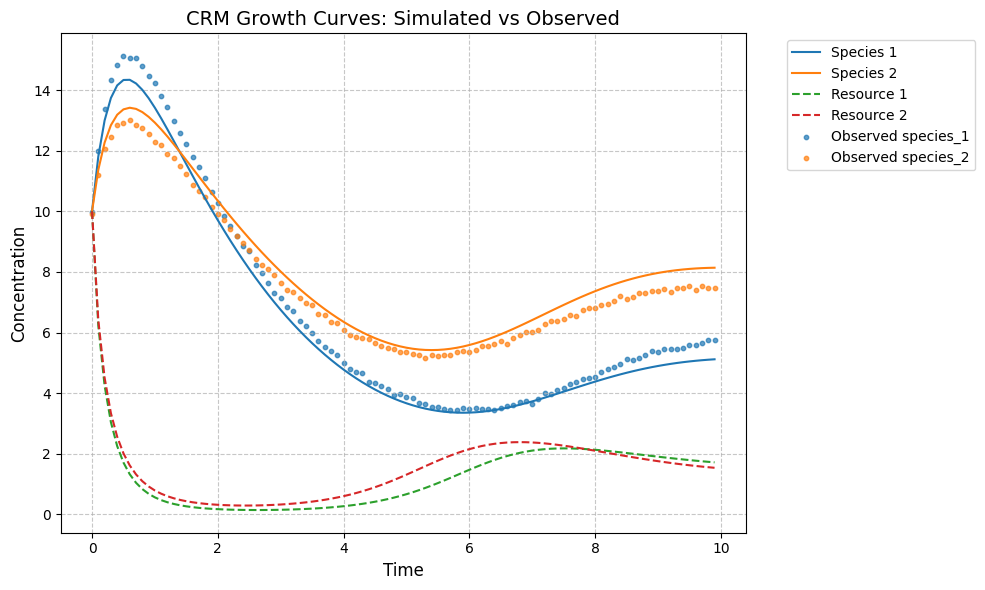

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'CRM Growth Curves: Simulated vs Observed'}, xlabel='Time', ylabel='Concentration'>)

In [11]:
# Plot the CRM

init_species = 10 * np.ones(num_species+num_resources)

# inferred parameters
tau_h = np.median(idata.posterior["tau_hat"].values, axis=(0,1))
w_h = np.median(idata.posterior["w_hat"].values, axis=(0,1))
c_h = np.median(idata.posterior["c_hat"].values, axis=(0,1))
m_h = np.median(idata.posterior["m_hat"].values, axis=(0,1))
r_h = np.median(idata.posterior["r_hat"].values, axis=(0,1))
K_h = np.median(idata.posterior["K_hat"].values, axis=(0,1))

compare_params(tau=(tau, tau_h), w=(w, w_h), c=(c, c_h), m=(m, m_h), r=(r, r_h), K=(K, K_h))

predictor = sim_CRM()

predictor.set_parameters(num_species = num_species,
                         num_resources = num_resources,
                         tau = tau_h,
                         w = w_h,
                         c = c_h,
                         m = m_h,
                         r = r_h,
                         K = K_h)

#predictor.print_parameters()

observed_species, observed_resources = predictor.simulate(times, init_species)
observed_data = np.hstack((observed_species, observed_resources))
 
# plot predicted species and resouce dynamics against observed data

plot_CRM(observed_species, observed_resources, times, 'data-s2-infer-r2.csv')

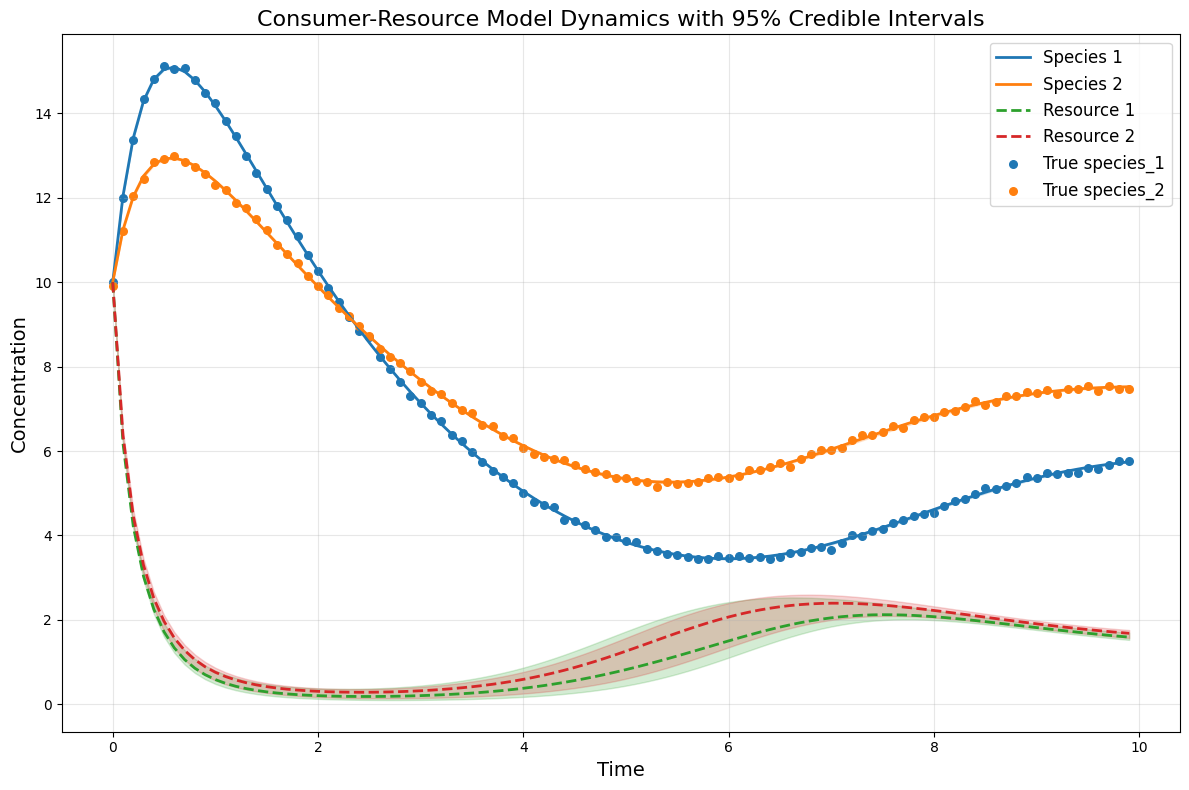

In [14]:
## Plot CRM  with confidence intervals

# Get posterior samples for c_hat 
tau_posterior_samples = idata.posterior["tau_hat"].values
w_posterior_samples = idata.posterior["w_hat"].values
c_posterior_samples = idata.posterior["c_hat"].values 
m_posterior_samples = idata.posterior["m_hat"].values
r_posterior_samples = idata.posterior["r_hat"].values
K_posterior_samples = idata.posterior["K_hat"].values

lower_percentile = 2.5
upper_percentile = 97.5

n_samples = 50
random_indices = np.random.choice(c_posterior_samples.shape[1], size=n_samples, replace=False)

# Store simulation results
all_species_trajectories = []
all_resource_trajectories = []

# Run simulations with different posterior samples
for i in range(n_samples):
    chain_idx = np.random.randint(0, c_posterior_samples.shape[0])
    draw_idx = np.random.randint(0, c_posterior_samples.shape[1])

    tau_sample = tau_posterior_samples[chain_idx, draw_idx]
    w_sample = w_posterior_samples[chain_idx, draw_idx]
    c_sample = c_posterior_samples[chain_idx, draw_idx]
    m_sample = m_posterior_samples[chain_idx, draw_idx]
    r_sample = r_posterior_samples[chain_idx, draw_idx]
    K_sample = K_posterior_samples[chain_idx, draw_idx]
    
    sample_predictor = sim_CRM()
    sample_predictor.set_parameters(num_species=num_species,
                                   num_resources=num_resources,
                                   tau=tau_sample,
                                   w=w_sample,
                                   c=c_sample,
                                   m=m_sample,
                                   r=r_sample,
                                   K=K_sample)

    
    sample_species, sample_resources = sample_predictor.simulate(times, init_species)
    
    # Store results
    all_species_trajectories.append(sample_species)
    all_resource_trajectories.append(sample_resources)


# Convert to numpy arrays
all_species_trajectories = np.array(all_species_trajectories)  
all_resource_trajectories = np.array(all_resource_trajectories)  

# Calculate percentiles across samples for each time point and species/resource
species_lower = np.percentile(all_species_trajectories, lower_percentile, axis=0)
species_upper = np.percentile(all_species_trajectories, upper_percentile, axis=0)
resource_lower = np.percentile(all_resource_trajectories, lower_percentile, axis=0)
resource_upper = np.percentile(all_resource_trajectories, upper_percentile, axis=0)

observed_species_mean = np.mean(all_species_trajectories, axis=0)  # Predicted species means
observed_resources_mean = np.mean(all_resource_trajectories, axis=0)  # Predicted resources means

# plot the CRM with confidence intervals
plot_CRM_with_intervals(observed_species_mean, observed_resources_mean,
                       species_lower, species_upper,
                       resource_lower, resource_upper,
                       times, 'data-s2-infer-r2.csv')